<h1 style="color:blue"> Bayesian Statistics and Probabilistic Programming</h1>

<h1 style="color:blue"> Spring 2022 - Homework 01</h1>

<h3 style="color:blue">2022-04-04</h3>

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exponential}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

<h1 style="color:blue">Instructions</h1>

### Submissions: 

By **groups** of _about_ three students (meaning: two is OK, four is not advisable but possible. Individual homeworks 
will also be accepted but collaborative work is preferable). 

Please send me an **email** with the team members names as soon as you have formed it.

Only **one copy** of each group's work must be uploaded (by any member)

### Format: 

A Jupyter or R Markdown **notebook,** with a **header** clearly stating the names of all contributors. 

### Documentation: 

Comments **in code cells** (e.g., meaning of variables, parameters, purpose of functions) are necessary but not sufficient.

You are expected to give full explanations of steps taken in your solution (in **Markdown cells**), as well as discussion of results and their meaning.

Do not drear being too verbose or too elementary.

### External sources

Getting inspiration from any book, document, blog, wep page, even mimicking solutions given in there, is **allowed and encouraged,** provided you give a **proper reference,**
understand every such material, and explain it in you own words, even more exhaustively.

Dare not **copy/paste literally.** I do detect it, believe me, even with a missing source reference. Bleak consequences.

### Deadline:

Completed assignments are due on Tuesday, April 19. They are to be uploaded to the Virtual Campus.

<h1 style="color:blue">01 - Stan version of a conjugate prior problem</h1>

<h2 style="color:blue">Modelling Earthquake Waiting Times</h2>

Consider the problem in `Exponential.02.Earthquake` (notebook in 2022-03-28 folder), where the goal is to study earthquake waiting times.

Likelihood is modelled as an $\expdist(\lambda)$ and $\lambda$ is given a conjugate prior, $\lambda\sim\gammadist(\alpha,\beta)$.

In this notebook some simulations are performed for:

01. Prior pdf for $\lambda$.
02. Prior predictive pdf for the waiting time.
03. Posterior pdf for $\lambda$.
04. Posterior predictive for new waiting time.

In `Exponential.02.Earthquake` we use known theoretical (analytical) descriptions of these distributions.

Your task is to redo these simulations using Stan, disregarding analytical conjugate prior formulas, and then comparing your results to the analytical ones. Use this comparison to tune up adjustable parameters in Stan sampling, such as chain length. 

**Solution:**

First, we load rstan and set the recommended options.

In [2]:
require(rstan)
parallel::detectCores()
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.5, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



[1] 4

Secondly, we write the stan code to generate samples from the prior. 

We know from the statement that $\lambda$ is given a conjugate prior, $\lambda\sim\gammadist(\alpha,\beta)$. Following the guidelines in ```S7.3.03.Exponential.02.Earthquake```we see that $\alpha$=1 and $\beta=30$, as a consecuence of setting the effective sample size to 1 and applying the formula for the expectation of a gamma distribution, given that E($\lambda$) is 1/30.

The Stan code simply draws samples from a gamma distribution, and we specify the parameters at runtime.

In [5]:
#Stan code to generate samples from the prior, 
#a gamma distribution of given alpha and beta
GammaPrior_String <- "
    //functions {}
    data{
        real<lower=0> alpha;
        real<lower=0> beta;
        }
    transformed data {}
    parameters{}
    transformed parameters {}
    model{ }
    generated quantities{
        real y=gamma_rng(alpha,beta);
        }
"
GammaPrior_stanDso <- stan_model( model_code=GammaPrior_String ) # Compile to DSO


Once that we have the DSO we input the selected distribution parameters and stan configuration to perform the simulation.

Configuration:
* chains	: A positive integer specifying the number of Markov chains. The default is 4.
* algorithm	: One of sampling algorithms that are implemented in Stan. No parameters in this scenario so we use "Fixed_param".
* seed	: The seed for random number generation.
* iter: A positive integer specifying the number of iterations for each chain (including warmup)
* warmup: A positive integer specifying the number of warmup (aka burnin) iterations per chain.
* thin: A positive integer specifying the period for saving samples. The default is 1, which is usually the recommended value.

In [6]:
#Specify runtime quantities and execute the code
prior.a<-1
prior.b<-30
Gamma_dataList <- list("alpha" = prior.a, "beta" = prior.b)

# Generate prior sample:
Gamma_stanFit <- sampling( object=GammaPrior_stanDso, 
                     data = Gamma_dataList, algorithm="Fixed_param",
                     chains = 4, seed = 24056, iter = 10000, warmup = 0, thin = 1)

Finally,  we extract the prior sample and plot its histogram together with the theoretical gamma distribution.

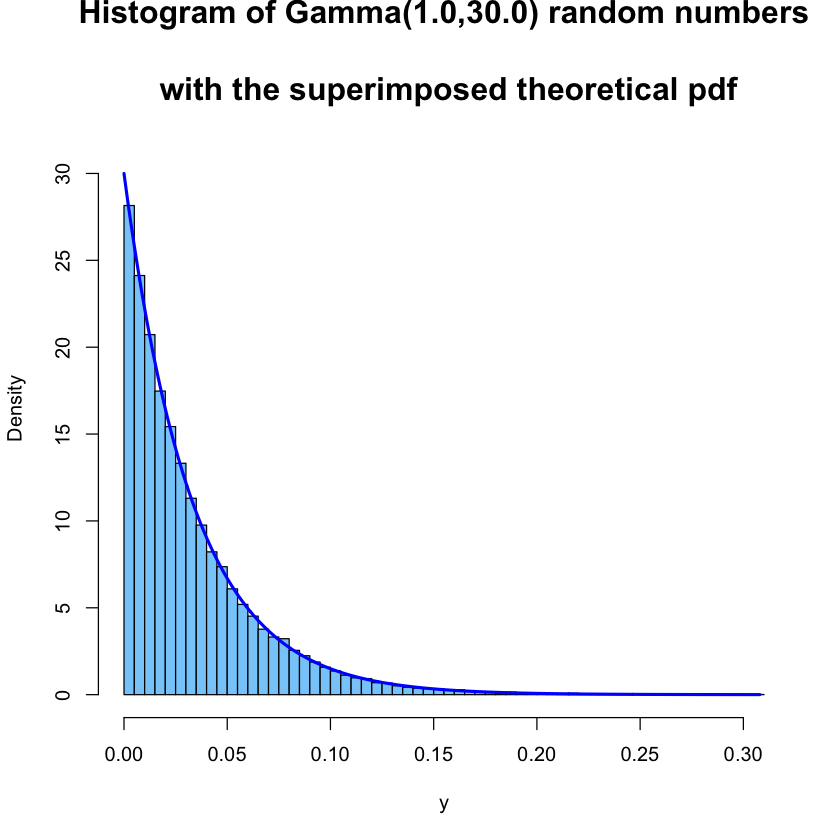

In [7]:
# extract sample and visualize it 
y<-extract(Gamma_stanFit,par="y")$y
y.max<-max(y)
u<-seq(0,y.max,length=1000)

#theoretical prior
df.theor<-dgamma(u,shape=prior.a,rate=prior.b)
f.max<-max(df.theor)
hist(y,freq=FALSE,col="LightSkyBlue",ylim=c(0,f.max*1.1),
     main=sprintf("Histogram of Gamma(%2.1f,%2.1f) random numbers
    \n with the superimposed theoretical pdf",prior.a,prior.b),nclass=60,cex.main=1.6)
lines(u,df.theor,lwd=2.5,col="blue")

<h1 style="color:blue">02 - A more elaborate mixture prior for the spinning coin</h1>

(continued from Diaconis experiment)

On reflection, it was decided that tails had come up more often than heads in the past; further some coins seemed likely to be symmetric. 

Thus, a final approximation to the prior was taken as:

$$
   \mskip-800mu 0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10).
$$

Same observed data as in the previous model.

In [1]:
# Number of trials
n<-10
# Observed x
x.obs<-3

Perform a complete Bayesian analysis of this model, in close parallel to the first example.

(1) Using the theoretical formulas (prior predictive pmf, posterior pdf, posterior predictive pmf)

(2) Using independent random numbers (`rbeta()` functions, etc.)

(3) JAGS version

(4)$ {}^{\star}$ Stan version. 

>$ (\star)$ Hint: this one **is difficult** due to intrinsic limitations in Stan. There are several known workarounds; you can try to find one but do not despair if you fail to develop a workable version.

>As a matter of fact even a Stan version of the two-components prior mixture in `Mixture.priors.02.ipynb` 
is rather tricky: Stan does not allow integer parameters thus the JAGS code cannot be translated literally.

Diaconis and Ylvisaker (1985) compare both mixture conjugate priors with a $ \operatorname{Unif}(0,1)$ prior with the data above. 

Comparing the MAP estimators, they observe that in a first approximation, they coincide, but spreads do depend on the prior.

They repeat the computations above with a larger sample. 

In [2]:
n1<-50
x1.obs<-14

Their conclusion is that with small data, prior matters, but with larger samples, a finely tuned choice of prior is less important.